In [2]:
import sympy
from sympy import Symbol, Sum, IndexedBase
from sympy.parsing.sympy_parser import parse_expr

In [3]:
a = IndexedBase("alpha", "i")
xr = IndexedBase("x_r", "i")
yr = IndexedBase("y_r", "i")
xl = IndexedBase("x_l", "i")
yl = IndexedBase("y_l", "i")

x = IndexedBase("x", "i")
y = IndexedBase("y", "i")

kp = Symbol("k_p")
kl = Symbol("k_l")

i = Symbol("i")
N = Symbol("N")

In [4]:
def print_latex(text, title="", fontsize=40):
  lat = sympy.latex(text)

  #add text                                                                       
  plt.text(0, 0.5, r"$%s = %s$" % (title, lat), fontsize=fontsize)                                  

  # #hide axes                                                                      
  fig = plt.gca()
  fig.axis('off')
  plt.draw()

## Formulation

In [5]:
import matplotlib.pyplot as plt

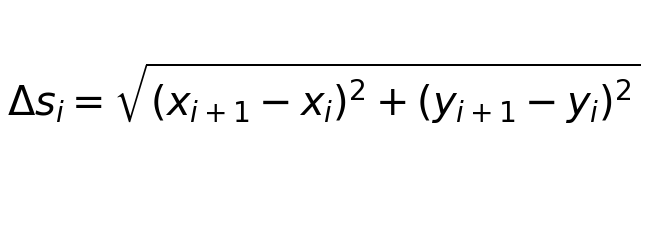

In [6]:
ds = sympy.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)
print_latex(ds, title=r"\Delta{s_i}")

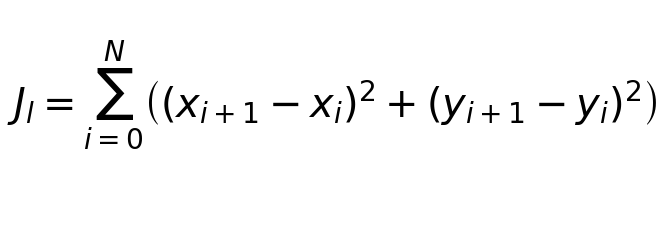

In [7]:
Jl = ds**2
print_latex(Sum(Jl, ("i", 0, N)), title="J_l")

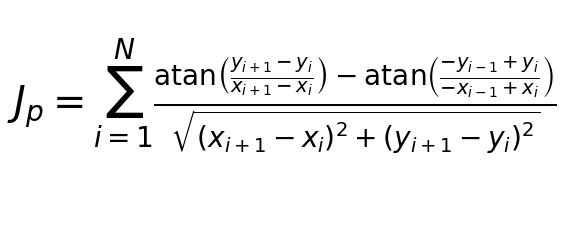

In [8]:
Jp = (sympy.atan((y[i+1]-y[i])/(x[i+1]-x[i]))-sympy.atan((y[i]-y[i-1])/(x[i]-x[i-1])))/(ds)
print_latex(Sum(Jp, ("i", 1, N)), title="J_p")

## Substitutions

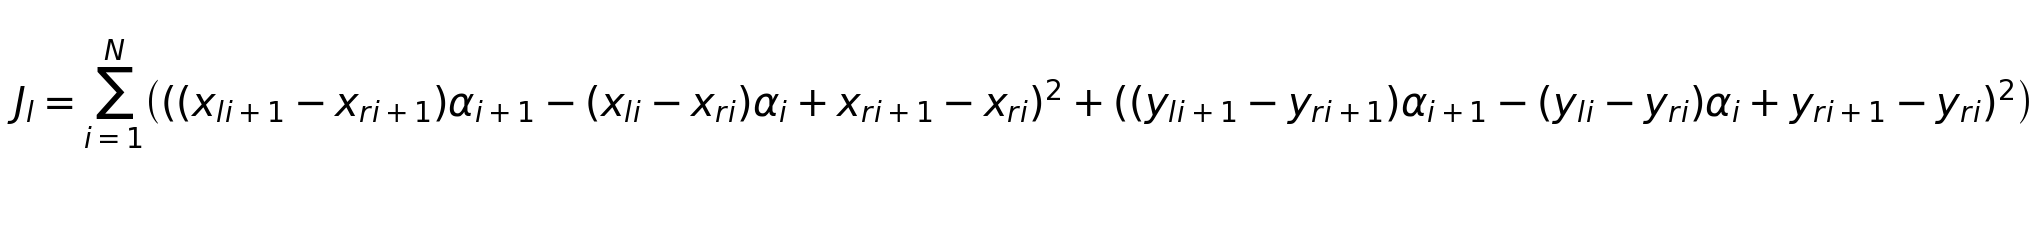

In [9]:
Jl = Jl \
    .subs(x[i+1], xr[i+1]+a[i+1]*(xl[i+1]-xr[i+1])) \
    .subs(x[i], xr[i]+a[i]*(xl[i]-xr[i])) \
    .subs(y[i], yr[i]+a[i]*(yl[i]-yr[i])) \
    .subs(y[i+1], yr[i+1]+a[i+1]*(yl[i+1]-yr[i+1]))

print_latex(Sum(Jl, ("i", 1, N)), title="J_l")

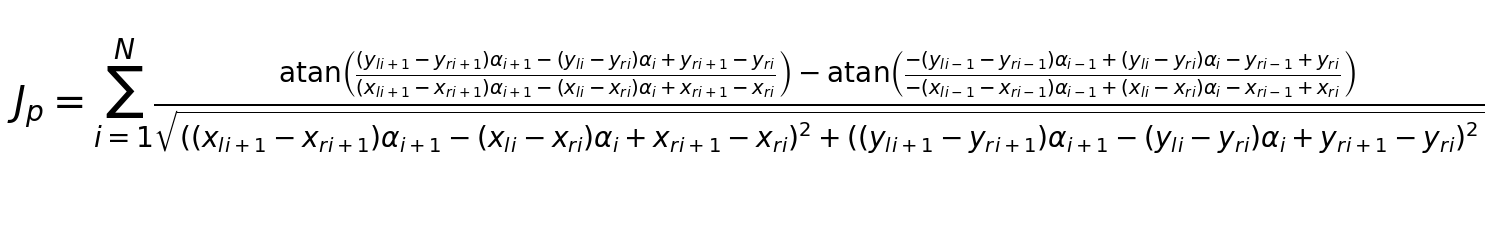

In [10]:
Jp = Jp \
    .subs(x[i+1], xr[i+1]+a[i+1]*(xl[i+1]-xr[i+1])) \
    .subs(x[i], xr[i]+a[i]*(xl[i]-xr[i])) \
    .subs(x[i-1], xr[i-1]+a[i-1]*(xl[i-1]-xr[i-1])) \
    .subs(y[i], yr[i]+a[i]*(yl[i]-yr[i])) \
    .subs(y[i+1], yr[i+1]+a[i+1]*(yl[i+1]-yr[i+1])) \
    .subs(y[i-1], yr[i-1]+a[i-1]*(yl[i-1]-yr[i-1]))

print_latex(Sum(Jp, ("i", 1, N)), title="J_p")

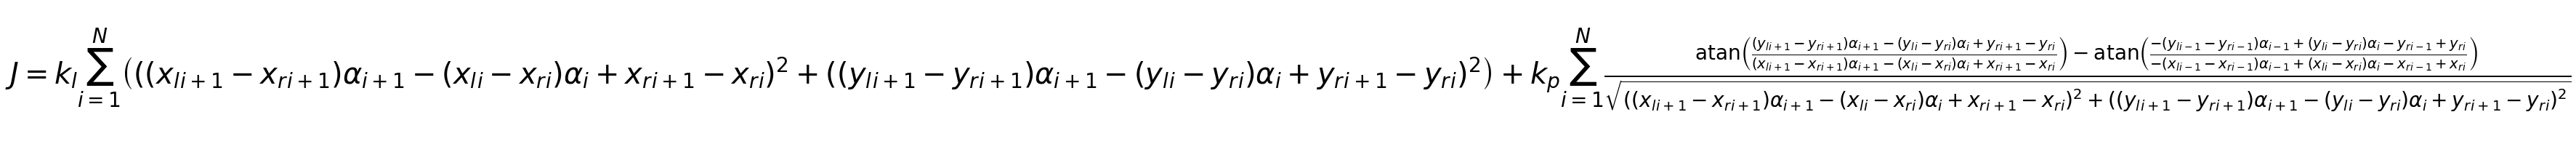

In [11]:
J = kl*Sum(Jl, ("i", 1, N)) + kp * Sum(Jp, ("i", 1, N))
print_latex(J, title="J")

## Gradient

In [15]:
def to_matlab(der):
  return sympy.ccode(der) \
    .replace("x_l[i]", "leftpoints(idx, 1)") \
    .replace("x_l[i + 1]", "leftpoints(idx+1, 1)") \
    .replace("x_r[i]", "rightpoints(idx, 1)") \
    .replace("x_r[i + 1]", "rightpoints(idx+1, 1)") \
    .replace("y_l[i]", "leftpoints(idx, 2)") \
    .replace("y_l[i + 1]", "leftpoints(idx+1, 2)") \
    .replace("y_r[i]", "rightpoints(idx, 2)") \
    .replace("y_r[i + 1]", "rightpoints(idx+1, 2)") \
    .replace("x_l[i - 1]", "leftpoints(idx-1, 1)") \
    .replace("y_l[i - 1]", "leftpoints(idx-1, 2)") \
    .replace("x_r[i - 1]", "rightpoints(idx-1, 1)") \
    .replace("y_r[i - 1]", "rightpoints(idx-1, 2)") \
    .replace("alpha[i]", "alpha(idx)") \
    .replace("alpha[i + 1]", "alpha(idx+1)") \
    .replace("alpha[i - 1]", "alpha(idx-1)") \
    .replace("pow", "power")

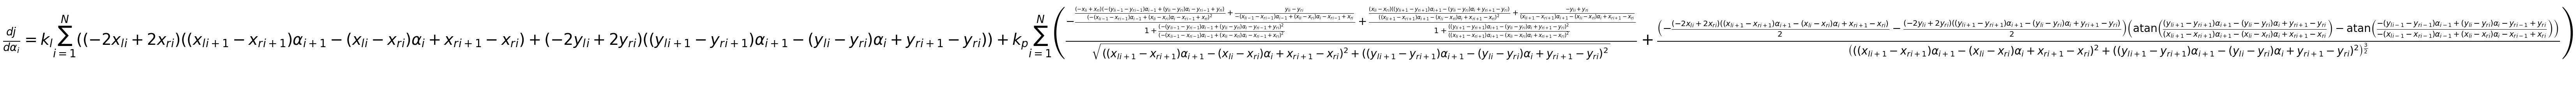

In [12]:
gradient = J.diff(a[i])
print_latex(gradient, title=r"\frac{dj}{d\alpha_i}")

In [16]:
# d/a
gradient_jl = Jl.diff(a[i])
gradient_code_jl = to_matlab(gradient_jl)
gradient_code_jl

'(-2*leftpoints(idx, 1) + 2*rightpoints(idx, 1))*((leftpoints(idx+1, 1) - rightpoints(idx+1, 1))*alpha(idx+1) - (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) + rightpoints(idx+1, 1) - rightpoints(idx, 1)) + (-2*leftpoints(idx, 2) + 2*rightpoints(idx, 2))*((leftpoints(idx+1, 2) - rightpoints(idx+1, 2))*alpha(idx+1) - (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) + rightpoints(idx+1, 2) - rightpoints(idx, 2))'

In [27]:
# d/a+1
gradient_jl_ap1 = Jl.diff(a[i+1])
gradient_code_jl_plus1 = to_matlab(gradient_jl_plus_1)
gradient_code_jl_plus1

'(2*leftpoints(idx+1, 1) - 2*rightpoints(idx+1, 1))*((leftpoints(idx+1, 1) - rightpoints(idx+1, 1))*alpha(idx+1) - (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) + rightpoints(idx+1, 1) - rightpoints(idx, 1)) + (2*leftpoints(idx+1, 2) - 2*rightpoints(idx+1, 2))*((leftpoints(idx+1, 2) - rightpoints(idx+1, 2))*alpha(idx+1) - (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) + rightpoints(idx+1, 2) - rightpoints(idx, 2))'

In [18]:
gradient_jp = Jp.diff(a[i])
gradient_code_jp = to_matlab(gradient_jp)
gradient_code_jp

'(-((-leftpoints(idx, 1) + rightpoints(idx, 1))*(-(leftpoints(idx-1, 2) - rightpoints(idx-1, 2))*alpha(idx-1) + (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2))/power(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2) + (leftpoints(idx, 2) - rightpoints(idx, 2))/(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1)))/(1 + power(-(leftpoints(idx-1, 2) - rightpoints(idx-1, 2))*alpha(idx-1) + (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2), 2)/power(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2)) + ((leftpoints(idx, 1) - rightpoints(idx, 1))*((lef

In [23]:
gradient_jp_plus_1 = Jp.diff(a[i+1])
gradient_code_jp_plus_1 = to_matlab(gradient_jp_plus_1)
gradient_code_jp_plus_1

'(-1.0/2.0*(2*leftpoints(idx+1, 1) - 2*rightpoints(idx+1, 1))*((leftpoints(idx+1, 1) - rightpoints(idx+1, 1))*alpha(idx+1) - (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) + rightpoints(idx+1, 1) - rightpoints(idx, 1)) - 1.0/2.0*(2*leftpoints(idx+1, 2) - 2*rightpoints(idx+1, 2))*((leftpoints(idx+1, 2) - rightpoints(idx+1, 2))*alpha(idx+1) - (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) + rightpoints(idx+1, 2) - rightpoints(idx, 2)))*(atan(((leftpoints(idx+1, 2) - rightpoints(idx+1, 2))*alpha(idx+1) - (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) + rightpoints(idx+1, 2) - rightpoints(idx, 2))/((leftpoints(idx+1, 1) - rightpoints(idx+1, 1))*alpha(idx+1) - (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) + rightpoints(idx+1, 1) - rightpoints(idx, 1))) - atan((-(leftpoints(idx-1, 2) - rightpoints(idx-1, 2))*alpha(idx-1) + (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2))/(-(leftpoints(idx-1, 1) - rightpoints(idx

In [24]:
gradient_jp_minus_1 = Jp.diff(a[i-1])
gradient_code_jp_minus_1 = to_matlab(gradient_jp_minus_1)
gradient_code_jp_minus_1

'-((leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*(-(leftpoints(idx-1, 2) - rightpoints(idx-1, 2))*alpha(idx-1) + (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2))/power(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2) + (-leftpoints(idx-1, 2) + rightpoints(idx-1, 2))/(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1)))/((1 + power(-(leftpoints(idx-1, 2) - rightpoints(idx-1, 2))*alpha(idx-1) + (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2), 2)/power(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2))*sqrt(power((leftpoints(idx+1, 1) - rightpoi

## Hessian

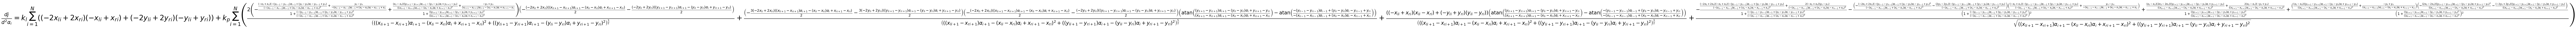

In [ ]:
hessian = gradient.diff(a[i])
print_latex(hessian, title=r"\frac{dj}{d^2\alpha_i}")

In [25]:
# Jl /a^2
hessian_jl = gradient_jl.diff(a[i])
hessian_code_jl = to_matlab(hessian_jl)
hessian_code_jl

'(-2*leftpoints(idx, 1) + 2*rightpoints(idx, 1))*(-leftpoints(idx, 1) + rightpoints(idx, 1)) + (-2*leftpoints(idx, 2) + 2*rightpoints(idx, 2))*(-leftpoints(idx, 2) + rightpoints(idx, 2))'

In [26]:
# Jl /a*ai+1
hessian_jl_a_ap1 = gradient_jl.diff(a[i+1])
hessian_code_jl_a_ap1 = to_matlab(hessian_jl_a_ap1)
hessian_code_jl_a_ap1

'(leftpoints(idx+1, 1) - rightpoints(idx+1, 1))*(-2*leftpoints(idx, 1) + 2*rightpoints(idx, 1)) + (leftpoints(idx+1, 2) - rightpoints(idx+1, 2))*(-2*leftpoints(idx, 2) + 2*rightpoints(idx, 2))'

In [29]:
# Jl /(a+1)^2
hessian_jl_ap1_ap1 = gradient_jl_ap1.diff(a[i+1])
hessian_code_jl_a_ap1 = to_matlab(hessian_jl_ap1_ap1)
hessian_code_jl_a_ap1

'(leftpoints(idx+1, 1) - rightpoints(idx+1, 1))*(2*leftpoints(idx+1, 1) - 2*rightpoints(idx+1, 1)) + (leftpoints(idx+1, 2) - rightpoints(idx+1, 2))*(2*leftpoints(idx+1, 2) - 2*rightpoints(idx+1, 2))'

In [ ]:
hessian_jp = gradient_jp.diff(a[i])
hessian_code_jp = sympy.ccode(hessian_jp) \
    .replace("x_l[i]", "leftpoints(idx, 1)") \
    .replace("x_l[i + 1]", "leftpoints(idx+1, 1)") \
    .replace("x_r[i]", "rightpoints(idx, 1)") \
    .replace("x_r[i + 1]", "rightpoints(idx+1, 1)") \
    .replace("y_l[i]", "leftpoints(idx, 2)") \
    .replace("y_l[i + 1]", "leftpoints(idx+1, 2)") \
    .replace("y_r[i]", "rightpoints(idx, 2)") \
    .replace("y_r[i + 1]", "rightpoints(idx+1, 2)") \
    .replace("x_l[i - 1]", "leftpoints(idx-1, 1)") \
    .replace("y_l[i - 1]", "leftpoints(idx-1, 2)") \
    .replace("x_r[i - 1]", "rightpoints(idx-1, 1)") \
    .replace("y_r[i - 1]", "rightpoints(idx-1, 2)") \
    .replace("alpha[i]", "alpha(idx)") \
    .replace("alpha[i + 1]", "alpha(idx+1)") \
    .replace("alpha[i - 1]", "alpha(idx-1)") \
    .replace("pow", "power")
hessian_code_jp

'2*(-((-leftpoints(idx, 1) + rightpoints(idx, 1))*(-(leftpoints(idx-1, 2) - rightpoints(idx-1, 2))*alpha(idx-1) + (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2))/power(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2) + (leftpoints(idx, 2) - rightpoints(idx, 2))/(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1)))/(1 + power(-(leftpoints(idx-1, 2) - rightpoints(idx-1, 2))*alpha(idx-1) + (leftpoints(idx, 2) - rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2), 2)/power(-(leftpoints(idx-1, 1) - rightpoints(idx-1, 1))*alpha(idx-1) + (leftpoints(idx, 1) - rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2)) + ((leftpoints(idx, 1) - rightpoints(idx, 1))*((l